In [2]:
#!pip install torchtext==0.4.0
#!pip install subword_nmt
# !pip install transformers
# !pip install navec
# !wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/Lib_2_actual

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/Lib_2_actual


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time


import matplotlib
import numpy as np
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from train_model import train
from get_score import show_results

In [5]:
# getting data
path_to_data = 'data/data.txt'
import data_preprocessing


data, SRC, TRG = data_preprocessing.get_dataset(path_to_data)
train_data, valid_data, test_data = data
PAD_IDX = TRG.vocab.stoi['<pad>']


def _len_sort_key(x):
    return len(x.src)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_iterators(train_data=train_data, 
                  valid_data=valid_data,
                  test_data=test_data,
                  batch_size=512):


    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data), 
        batch_size = batch_size, 
        device = device,
        sort_key=_len_sort_key
    )
    return train_iterator, valid_iterator, test_iterator

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 9259
Unique tokens in target (en) vocabulary: 6718


### 1. Seq_to_seq with attention



Encoder - one layer bidirectional GRU, Decoder - one layer GRU.
В целом эта архитектура отличается от baseline модели тем что LSTM заменен на GRU и добавлен механизм attention. Это привело к повышению BLUE до 31. Так как концептуально GRU от LSTM мало чем отличается, основной прирост качества связан с добавлением механизма attention

In [ ]:
import gru_attention
train_iterator, val_iterator, test_iterator = get_iterators(batch_size = 128)
gru_att_model = gru_attention.get_model(SRC, TRG)

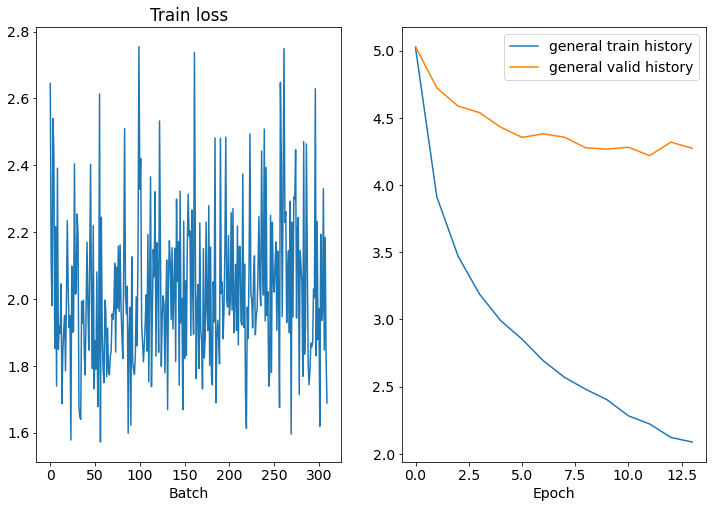

Epoch: 15 | Time: 4m 13s
	Train Loss: 2.022 | Train PPL:   7.553
	 Val. Loss: 4.250 |  Val. PPL:  70.101


In [ ]:
optimizer = optim.Adam(gru_att_model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

train(gru_att_model, "gru_att_model", train_iterator, 
     val_iterator, optimizer, scheduler, criterion, n_epochs = 15, transformer = False)

In [ ]:
show_results(gru_att_model, test_iterator, SRC.vocab, TRG.vocab, 128, transformer = False)

The model has 23,784,157 trainable parameters


59it [00:15,  3.91it/s]


BLEU score: 31.096980681162385
Время на inference в пересчете на один батч размером 32: 0.05305112115407394 seconds

Successful examples of translation:

	 Original: there is a bowling alley offered .
	 Generated: there is also bowling alley .

	 Original: free public parking is possible near the property .
	 Generated: free public parking is available nearby .

	 Original: free private parking is available .
	 Generated: free private parking is available on site .

Bad translation examples: 

	 Original: they are at your disposal 24 hours a day .
	 Generated: the hotel has a 24 - hour front desk at the property .

	 Original: the lobby is open 24 hours .
	 Generated: the hotel ’ s 24 - hour front desk is available .

	 Original: the kitchen is fitted with an oven .
	 Generated: an oven is equipped with an oven .



### 2. Seq_to_seq with attention using as Encoder- bidirectinal GRU and pretrained embeddings.

Используется та же самая архитектура, только для токенов используются предобученные embeddings. Для русского языка эмбединги берутся с https://github.com/natasha/navec, а для английского использована модель  ```glove-wiki-gigaword-300```. Это привело к небольшому снижению скора.

In [ ]:
import gru_attention
gru_att_pretr_model = gru_attention.get_model(SRC, TRG, pretr = True)
batch_size = 128
train_iterator, valid_iterator, test_iterator = get_iterators(batch_size=batch_size)

[=================================================-] 98.2% 369.3/376.1MB downloaded

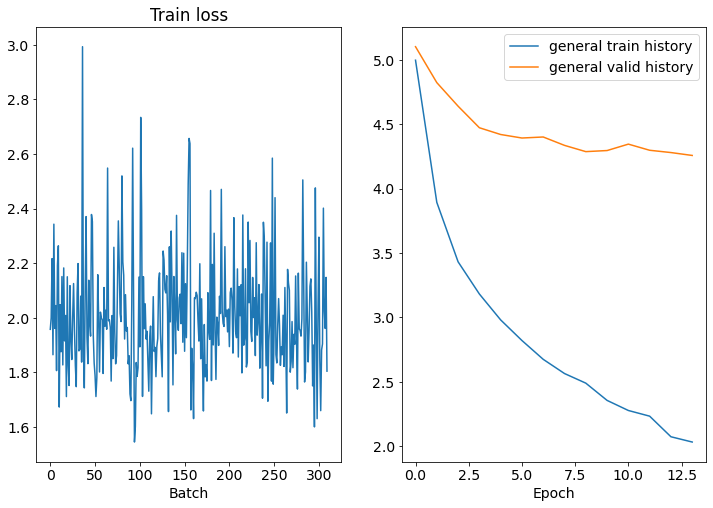

Epoch: 15 | Time: 3m 30s
	Train Loss: 2.009 | Train PPL:   7.457
	 Val. Loss: 4.297 |  Val. PPL:  73.511


In [ ]:
optimizer = optim.Adam(gru_att_pretr_model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

train(gru_att_pretr_model, "gru_att_pretr_model", train_iterator, 
     valid_iterator, optimizer, scheduler, criterion, n_epochs = 15, transformer = False)

In [ ]:
show_results(gru_att_pretr_model, test_iterator, SRC.vocab, TRG.vocab, batch_size, transformer = False)

The model has 23,784,157 trainable parameters


59it [00:10,  5.88it/s]


BLEU score: 30.034437687740343
Время на inference в пересчете на один батч размером 32: 0.03186509770862127 seconds

Successful examples of translation:

	 Original: certain rooms feature a seating area to relax in after a busy day .
	 Generated: some units feature a seating area for your convenience .

	 Original: a hairdryer is provided upon request .
	 Generated: a hairdryer and a can be arranged upon request .

	 Original: you will find a kettle in the room .
	 Generated: you will find a kettle in the room .

Bad translation examples: 

	 Original: free parking is available on site .
	 Generated: free parking is available on site .

	 Original: free wifi access is available .
	 Generated: free wifi access is available in all areas .

	 Original: there is a 24 - hour front desk at the property .
	 Generated: there is a 24 - hour front desk at the property .



### 3. Seq_to_seq with CNN-encoder

В качестве encoder выступает сверточная нейронная сеть, а в качестве decoder - однослойный GRU. В сверточной сети берутся одномерные ядра размерами 5, 3 и 2, а также positinal encoding. Качество модели намного ниже чем в предыдущих случаях, но выше чем для baseline модели).

In [ ]:
import seq_to_seq_with_cnn

batch_size = 128
ss_cnn_model = seq_to_seq_with_cnn.get_model(SRC, TRG)
train_iterator, valid_iterator, test_iterator = get_iterators(batch_size=batch_size)

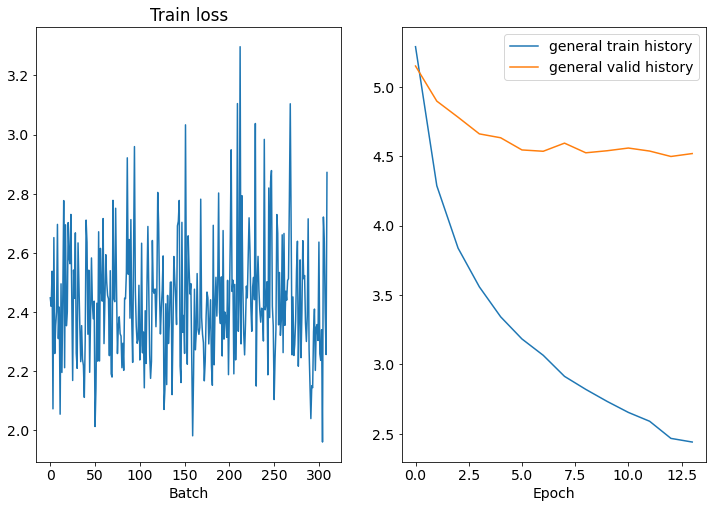

Epoch: 15 | Time: 1m 49s
	Train Loss: 2.434 | Train PPL:  11.400
	 Val. Loss: 4.517 |  Val. PPL:  91.593


In [ ]:
optimizer = optim.Adam(ss_cnn_model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

train(ss_cnn_model, "ss_cnn_model", train_iterator, 
     valid_iterator, optimizer, scheduler, criterion, n_epochs = 15, transformer = False)

In [ ]:
show_results(ss_cnn_model, test_iterator, SRC.vocab, TRG.vocab, batch_size, transformer = False)

The model has 9,904,965 trainable parameters


59it [00:07,  7.87it/s]


BLEU score: 20.730888822734737
Время на inference в пересчете на один батч размером 32: 0.028970033435498255 seconds

Successful examples of translation:

	 Original: there is a shared kitchen at the property .
	 Generated: there is a shared kitchen at the property .

	 Original: a flat - screen tv is provided .
	 Generated: rooms are fitted with flat flat - screen tv .

	 Original: entertainment is provided every day of the week .
	 Generated: the hotel is is served daily the best 06 : 00 to the : 00 .

Bad translation examples: 

	 Original: all rooms come with a tv .
	 Generated: all rooms are fitted with a tv and a channels .

	 Original: guests will enjoy a sweet breakfast every morning .
	 Generated: sweet sweet breakfast is served every morning . morning .

	 Original: the hotel also offers car hire .
	 Generated: bike hire is available at the hotel hotel is popular for explore the surroundings



### 4. Transformer.

Далее реализуем архитектуру из знаменитой статьи "Attention is all you need", код взят [отсюда](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb), c небольшими изменениями - а именно, обычный  positinal_encoding через тригонометрические функции заменен на обучаемый nn.Embedding слой (это приводит к большему скору), n_heads = 8, n_layers = 3

In [ ]:
import Transformer

batch_size = 128
model_transformer = Transformer.get_model(SRC, TRG)
train_iterator, valid_iterator, test_iterator = get_iterators(batch_size=batch_size)

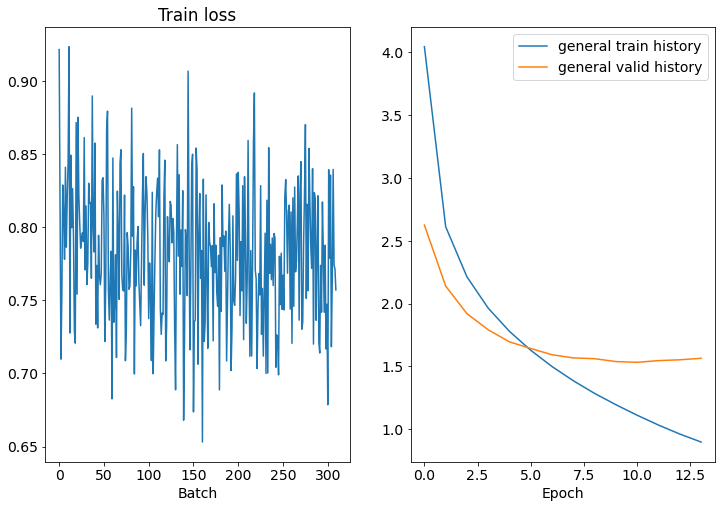

Epoch: 15 | Time: 1m 17s
	Train Loss: 0.781 | Train PPL:   2.183
	 Val. Loss: 1.559 |  Val. PPL:   4.756


In [ ]:
optimizer = optim.Adam(model_transformer.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

train(model_transformer, "transformer", train_iterator, 
     valid_iterator, optimizer, scheduler, criterion, n_epochs = 15, transformer = True)

In [ ]:
show_results(model_transformer, test_iterator, SRC.vocab, TRG.vocab, batch_size, transformer = True)

The model has 33,805,893 trainable parameters


59it [11:24, 11.59s/it]


BLEU score: 33.39969763038766
Время на inference  в пересчете на один батч размером 32: 2.909225138346354 seconds

Successful examples of translation:

	 Original: you will find a 24 - hour front desk at the property .
	 Generated: you will find a 24 - hour front desk at the property .

	 Original: the apartment is located on the 1st floor and features a kitchen with a microwave .
	 Generated: this apartment is located on the first floor of the apartment .

	 Original: you will find a 24 - hour front desk at the property .
	 Generated: you will find a 24 - hour front desk at the property .

Bad translation examples: 

	 Original: laundry facilities are available for all guests of the hotel .
	 Generated: laundry services are available .

	 Original: the property offers free parking .
	 Generated: the property offers free parking .

	 Original: it also includes an outdoor pool .
	 Generated: an outdoor pool is also available .



### 5. Bert encoder

Здесь Encoder - предобученный ruBert ([DeepPavlov](https://huggingface.co/DeepPavlov/rubert-base-cased-sentence)) с замороженными весами, Decoder - однослойный GRU. Также используется attention. Качество для этой модели оказалось ниже ожидаемого(( 

In [6]:
import Bert_attention

In [7]:
data, SRC, TRG = data_preprocessing.get_dataset(path_to_data, BERT=True)
train_data, valid_data, test_data = data
PAD_IDX = TRG.vocab.stoi['<pad>']

batch_size = 64
train_iterator, valid_iterator, test_iterator = get_iterators(train_data=train_data, 
                                                              valid_data=valid_data,
                                                              test_data=test_data,
                                                              batch_size=batch_size)

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
Unique tokens in source (ru) vocabulary: 11356
Unique tokens in target (en) vocabulary: 6718


In [8]:
model_bert = Bert_attention.get_model(SRC, TRG)

Downloading:   0%|          | 0.00/678M [00:00<?, ?B/s]

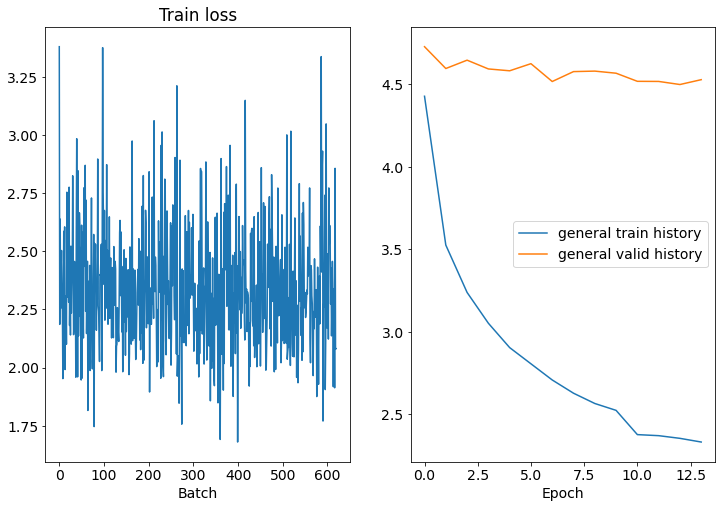

Epoch: 15 | Time: 7m 41s
	Train Loss: 2.335 | Train PPL:  10.331
	 Val. Loss: 4.528 |  Val. PPL:  92.559


In [9]:
optimizer = optim.Adam(model_bert.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

train(model_bert, "model_bert", train_iterator, 
     valid_iterator, optimizer, scheduler, criterion, n_epochs = 15, transformer = False)

In [10]:
show_results(model_bert, test_iterator, SRC.vocab, TRG.vocab, batch_size, transformer = False)

The model has 19,079,742 trainable parameters


118it [00:18,  6.34it/s]


BLEU score: 18.381909905635148
Время на inference в пересчете на один батч размером 32: 0.02850231376744933 seconds

Successful examples of translation:

	 Original: guests can enjoy a drink in the bar .
	 Generated: there is also a bar and a bar .

	 Original: a hot breakfast is served each morning at this hotel .
	 Generated: a is served each morning and a hot breakfast is served every morning , and a hot breakfast

	 Original: private bathrooms have a shower .
	 Generated: private bathrooms come with a shower shower shower shower .

Bad translation examples: 

	 Original: you can park your car free of charge on site .
	 Generated: free parking is available on site and free parking is provided on site .

	 Original: free parking is available in the garden
	 Generated: free parking is available on site garden and free parking is provided on site

	 Original: its en suite bathrooms come with shower facilities .
	 Generated: private bathroom comes with a shower and a shower .



Подведем итоги:
 - Лучшая модель относительно BLEU - transformer.
 - Нииболее быстрые модели на inference - Bert_encoder и cnn_encoder.

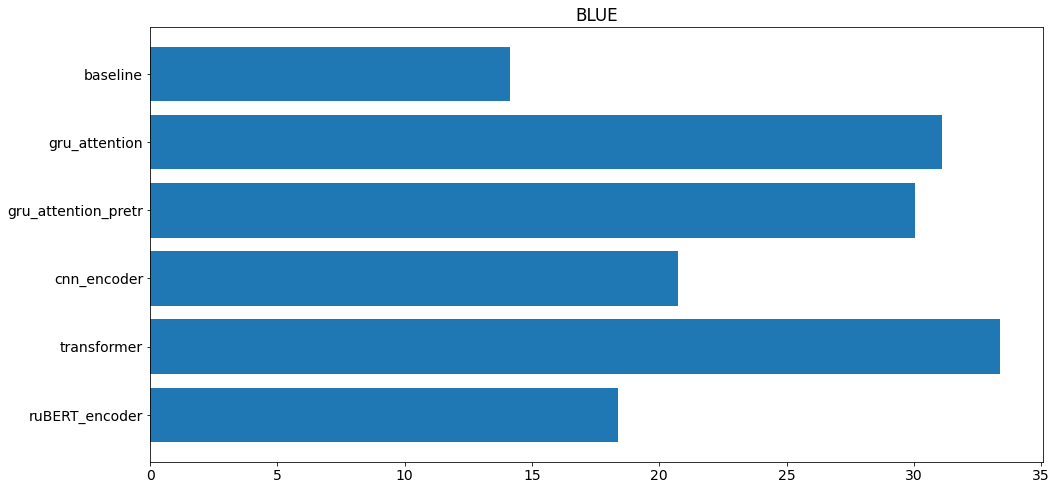

In [7]:
fig, ax = plt.subplots()
models = ["baseline", "gru_attention", "gru_attention_pretr", "cnn_encoder", "transformer", "ruBERT_encoder"]
scores =  [ 14.140,        31.097,            30.034,            20.731,      33.400,       18.382]
y_pos = np.arange(len(models))
plt.barh(models, scores,  align='center')
ax.set_yticks(y_pos)
ax.invert_yaxis()
ax.set_title('BLUE');